In [33]:
import shutil
from IPython.display import FileLink
import pandas as pd
import re
from IPython.display import display
from ipyfilechooser import FileChooser
from tqdm import tqdm
import os
import numpy as np
import sys
from tabulate import tabulate

from datetime import date

from prettytable import PrettyTable
from pathlib import Path

import json

import csv
from io import StringIO
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Image, Paragraph
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Table, TableStyle, PageBreak, Spacer, Image, Frame, PageTemplate
from reportlab.graphics.shapes import Drawing, Line
import os
import glob

# ignore group warnings
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
warnings.filterwarnings("ignore", 'This pattern is interpreted as a regular expression, and has match groups')

# Add complete filepath here.
filepath = sys.argv[1] if len(sys.argv) > 1 else ''
# uncomment for local testing the following
# filepath = "./ProductionTradeSupplyFuelOil_MVP02_EF_20240712.csv"
zip = sys.argv[2].lower() == 'true' if len(sys.argv) > 2 else False

filename = Path(filepath).stem
folder_to_download = filename  # Use the same name as the CSV file you are feeding in. At the very bottom of the page, once the report is generated, a Zip file becomes available to download.

In [34]:
# open docs/Geographies.csv and put values into a dataframe
df_geography = pd.read_csv('./docs/Geographies.csv', delimiter=',', header=0)
df_geography = df_geography['Shortname']

# open docs/Units.csv and put values into a dataframe
df_units = pd.read_csv('./docs/Units.csv', delimiter=',', header=0)
df_units = df_units['Abbreviation']


In [35]:
# Open the JSON file and load columns into variables
with open("docs/columns.json", 'r') as json_file:
    # Load the JSON data into a Python object
    data = json.load(json_file)
    universal_tabular_columns = data["universal_tabular_columns"]
    non_discerning_columns = data["non_discerning_columns"]
    df_mandatory_ef_columns = data["mandatory_columns_ef"] # Emission Factors
    df_mandatory_c_columns = data["mandatory_columns_cl"] # Compositions

# Open the JSON file and load graph repetition comparison into variables
with open("docs/graph_repetition_comparison.json", 'r') as json_file:
    # Load the JSON data into a Python object
    data = json.load(json_file)
    graph_repetition = data

In [36]:
def format_number_with_commas(number):
    try:
        # Ensure the number is an integer
        number = int(number)
        # Format the number with commas
        return f"{number:,}"
    except ValueError:
        return "Invalid number"

In [37]:
def draw_graph(range_vals, percent_vals, graph_name, save_path):
    # draw line graph where range_vals would be x values and percent_vals would be y values
    import matplotlib.pyplot as plt
    from itertools import zip_longest as zip

    # Set the figure size and background color
    plt.figure(figsize=(12, 8), facecolor='#131415')

    print(graph_name, range_vals, percent_vals)

    # Draw line graph where range_vals would be x values and percent_vals would be y values
    plt.plot(range(len(range_vals)), percent_vals, marker='s', color='#FFC80F',  zorder=5, linewidth=1, markersize=5)

    # Draw the second line graph if provided
    comparison_line = graph_repetition[graph_name]
    second_range_vals = comparison_line[0]
    second_percent_vals = comparison_line[1]
    plt.plot(range(len(second_range_vals)), second_percent_vals, marker='s', color='#4C4C4D', zorder=4,linewidth=1, linestyle='dashed', markersize=10)

    # Set the x-ticks to be evenly spaced indices
    plt.xticks(range(len(range_vals)), [f"{val} \n ({percent*100:.1f}%)" for val, percent in zip(range_vals, percent_vals)], color='#E9E9E9')

    # Set the y-ticks with custom color
    plt.yticks(color='#E9E9E9')

    # Label the axes
    plt.xlabel('Range Values',  color=(1., 1., 1., .65))
    plt.ylabel('Percent',  color=(1., 1., 1., .65))

    # Title of the plot
    plt.title(graph_name, color=(1., 1., 1., .65))

    # Set the grid color to white
    plt.grid(True,  color='#2F3031')

    # Set the background color of the plot area to black
    plt.gca().set_facecolor('#131415')

    # Remove the border around the graph
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Set the y-axis limits to always be from 0 to 1
    plt.ylim(-0.05, 1.05)

    # Set tick parameters to ensure visibility
    # plt.tick_params(axis='x', color='#2F3031')
    # plt.tick_params(axis='y', color='#2F3031')

    # Save the plot to the specified path
    plt.savefig(save_path, facecolor='#131415')

    # Show the plot
    # plt.show()

In [38]:
# change if there is an error reading csv or it is strangely formatted
# df = pd.read_csv(filepath, on_bad_lines='skip')
# df = pd.read_csv(filepath)
df = pd.read_csv(filepath, engine="python", encoding='utf-8', on_bad_lines='warn')
# df = pd.read_csv(filepath, sep='delimiter', header=None)

# add index to match the csv
df.index += 2

# print(df.columns)

# set current date
today = date.today()

# YYmmdd
CURRENT_DATE = today.strftime("%Y%m%d")

# CREATE FOLDERS
# create a folder for each document
FOLDER_NAME = re.sub("[^A-Z0-9]", " ", filename,0,re.IGNORECASE)
FOLDER_NAME = re.sub(' +', '_', FOLDER_NAME)

FOLDER_PATH = os.path.join(os.getcwd(), FOLDER_NAME)
print(f'Folder path : {FOLDER_PATH}')
if not os.path.exists(FOLDER_PATH):
    os.mkdir(FOLDER_PATH)

# formatting
if not os.path.exists(f"{FOLDER_PATH}/FORMATTING"):
    os.mkdir(f"{FOLDER_PATH}/FORMATTING")

# repetition
if not os.path.exists(f"{FOLDER_PATH}/REPETITION"):
    os.mkdir(f"{FOLDER_PATH}/REPETITION")

# other
if not os.path.exists(f"{FOLDER_PATH}/OTHER"):
    os.mkdir(f"{FOLDER_PATH}/OTHER")

# PRINT TABLE
MASTER_TABLE = ""
CMD_TABLE= []
def add_to_cmd_table(name, value, mandatory=False):
    global CMD_TABLE
    if mandatory:
        value = "\033[1;31;40m" + value + "\033[0m"
    CMD_TABLE.append([name, value])

def print_table(table, horizontal, column_headers = []):
    global MASTER_TABLE
    tab = None
    if horizontal:
        tab = PrettyTable(table[0])
        tab.add_rows(table[1:])
    else:
        tab = PrettyTable()
        for index, item in enumerate(column_headers):
            tab.add_column(item, table[index])
    tab.padding_width = 2
    tab.junction_char = '.'
    # print(tab)
    MASTER_TABLE += tab.get_csv_string()
    MASTER_TABLE += "-\n"
    MASTER_TABLE += "-\n"
    MASTER_TABLE += "-\n"

# print(df.iloc[df.shape[0]-1])
# print(df.shape[0])
# # Drop rows with any empty cells // put more threshold to kick the strange ones
# df.dropna(how='all',thresh=1, inplace=True)
# print(df.shape[0])

MASTER_TABLE += "Total data points\n"
MASTER_TABLE += f"{df.shape[0]}\n"
MASTER_TABLE += "-\n"
MASTER_TABLE += "-\n"
MASTER_TABLE += "-\n"

# print(len(df.columns))

Folder path : /Users/kazkas/Desktop/T_CIRCA-Desktop/2024/CODE/DATACHECKER/ProductionTradeSupplyFuelOil_MVP02_EF_20240712


In [39]:
# check whether existing columns are in the same names as universal tabular columns
for index, item in enumerate(df.columns):
    if item not in universal_tabular_columns:
        print(f'this is not the right name : {item}')

# add missing columns 
for index, item in enumerate(universal_tabular_columns):
    if item not in df.columns:
        print(f'the column was added : {item}')
        # df[item] = pd.Series()
        df[item] = pd.Series(dtype='object')

In [40]:
# make the data incorrect

df.loc[7,'Source'] = None
df.loc[7,'Value'] = "12"
df.loc[7,'Name'] = "$$ test"
df.loc[7,'Description'] = "test  this"
df.loc[8,'Name'] = "test this?"
# row 2 should be equal to row 1

# duplication
for index, item in enumerate(df.columns):
    df.loc[4,item] = df.loc[3,item]

# non discenrning
for index, item in enumerate(df.columns):
    if item in non_discerning_columns:
        df.loc[5,item] = df.loc[4,item]


df.loc[2, 'Name'] = np.nan
df.loc[2, 'Description'] = np.nan

In [41]:
def duplicates_non_discerning(dataFrame, df_columns, table_text, analyse_name):
    global MASTER_TABLE
    # finds all duplicate rows and keeps all of them
    df_local = dataFrame[df_columns]
    df_range = df_local[df_local.duplicated(keep=False)]

    # sort based on the first column
    df_range = df_range.sort_values(by=[df_columns[0]])

    # total dataframe count
    df_count = dataFrame.shape[0]
    
    # Number of instances
    df_instance_count = df_range.shape[0]

    # Number of records that would be removed
    df_without_range = df_local.drop_duplicates()
    df_range_count = df_count - df_without_range.shape[0]

    # - % of total data affected (copies/total)
    df_range_percent = df_range_count / df_count

    # print(f"{analyse_name}")
    MASTER_TABLE += f"{analyse_name}\n"

    # if there are no values exit
    if df_range_percent == 0:
        MASTER_TABLE += "PASS\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        add_to_cmd_table(analyse_name, "PASS")
        return
    add_to_cmd_table(analyse_name, "FIX", True)
    
    table = [table_text, [df_instance_count, df_range_count, df_range_percent]]
    print_table(table, True)

    # SAVE FILES
    # save - Rows that are duplicated - OUTPUT 1
    df_range_full_table = dataFrame.loc[df_range.index]
    df_range_full_table.to_csv(f'{FOLDER_PATH}/OTHER/Report-{analyse_name}-Output_1-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')
    
    # print(f"Saved — {analyse_name}-Report-Output_1")

    # save - Duplicate instances & number of each - OUTPUT 2
    # count the duplicates
    df_range_group = df_range.groupby(df_range.columns.tolist(),as_index=False, dropna=False, sort=True).size()
    # add count to begining
    df_range_group.insert(0, "count", df_range_group["size"])
    # remove size at the end
    df_range_group.pop('size')
    # sort values by count
    df_range_group = df_range_group.sort_values(by="count", ascending=False)
    # reset index
    df_range_group = df_range_group.reset_index(drop=True)
    # save
    df_range_group.to_csv(f'{FOLDER_PATH}/OTHER/Report-{analyse_name}-Output_2-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')

# DUPLICATES
table_text = ['Number of instances', 'Number of records that would be removed', '% of total data affected (copies/total)']
duplicates_non_discerning(df, df.columns, table_text, "Duplication")

# drop duplicates
df = df.drop_duplicates()

# NON DISCERNING-INFO
table_text = ['Number of instances', 'Number of records that indiscernable', '% of rows of the total data affected (copies/total)']
duplicates_non_discerning(df, non_discerning_columns, table_text, "Non_discerning_info")

In [42]:
def missing_value(dataFrame):
    global MASTER_TABLE

    # total dataframe count
    df_count = dataFrame.shape[0]

    def change_missing_values(mvv):
        mvv_changed = []
        for i in mvv:
            val = i
            if i == 0:
                val = "full"
            elif i == df_count:
                val = "---"
            mvv_changed.append(val)
                
        return mvv_changed

    # check whether it is emmission factor or composition
    if dataFrame["Value"].isna().sum() == df_count:
        df_mandatory_columns= df_mandatory_c_columns
    else:
        df_mandatory_columns= df_mandatory_ef_columns
    df_optional = dataFrame.drop(columns = df_mandatory_columns) # mandatory dataframe
    df_mandatory = dataFrame[df_mandatory_columns] # mandatory dataframe
    
    # MANDATORY
    missing_value_table = df_mandatory.isna().sum()
    missing_value_values = change_missing_values(missing_value_table.tolist())
    
    # save misisng value table
    MASTER_TABLE += f"Missing_value_mandatory\n"

    # if it does not miss any values
    if len([x for x in missing_value_values if x != "full"]) == 0:
        MASTER_TABLE += "PASS\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        add_to_cmd_table("Missing_value_mandatory", "PASS")
    else:
        table = [missing_value_table.index.tolist(), missing_value_values]
        print_table(table, False, ["Column", "Count"])
        add_to_cmd_table("Missing_value_mandatory", "FIX", True)

        # go trough each column in the dataFrame and check which columns misses somve values. If it does, save the document
        for col_name, val in missing_value_table.items():
            if val != dataFrame.shape[0] and val != 0:
                cn = re.sub("[^A-Z]", " ", col_name,0,re.IGNORECASE)
                cn = re.sub(' +', '_', cn)
                fname = f'{FOLDER_PATH}/OTHER/Report-Missing_value_mandatory-{cn}-Output_1-{filename}-{CURRENT_DATE}.csv'
                df_isna = dataFrame[dataFrame[col_name].isna()]
                df_isna.to_csv(fname,encoding='utf-8')
    
    # OPTIONAL
    missing_value_table = df_optional.isna().sum()
    missing_value_values = change_missing_values(missing_value_table.tolist())
    
    # save misisng value table
    MASTER_TABLE += f"Missing_value_optional\n"

    # if it does not miss any values
    table = [missing_value_table.index.tolist(), missing_value_values]
    print_table(table, False, ["Column", "Count"])

    # go trough each column in the dataFrame and check which columns misses somve values. If it does, save the document
    for col_name, val in missing_value_table.items():
        if val != dataFrame.shape[0] and val != 0:
            cn = re.sub("[^A-Z]", " ", col_name,0,re.IGNORECASE)
            cn = re.sub(' +', '_', cn)
            fname = f'{FOLDER_PATH}/OTHER/Report-Missing_value_optional-{cn}-Output_1-{filename}-{CURRENT_DATE}.csv'
            df_isna = dataFrame[dataFrame[col_name].isna()]
            df_isna.to_csv(fname,encoding='utf-8')


missing_value(df)

Repetition_1 | The Name instance [2, 5, 10, 25, 50, 100, 1000, 10000] [0.9999576033154207, 0.9999364049731311, 0.9999364049731311, 0.9995548348119178, 0.9988976862009391, 0.9967142569451068, 0.8653693281185412, 0.0]
Repetition_2 | The Description instance [2, 5, 10, 25, 50, 100, 1000, 10000] [0.9999788016577104, 0.9999788016577104, 0.9999788016577104, 0.9999788016577104, 0.9999788016577104, 0.9999788016577104, 0.9999788016577104, 0.9999788016577104]
Repetition_4 | The Value instance [2, 5, 10, 25, 50, 100, 1000, 10000] [0.9762896541490456, 0.9003253945541458, 0.8332220420363128, 0.7418889842814292, 0.6663168940188877, 0.5598376206980614, 0.2330121784476454, 0.0]


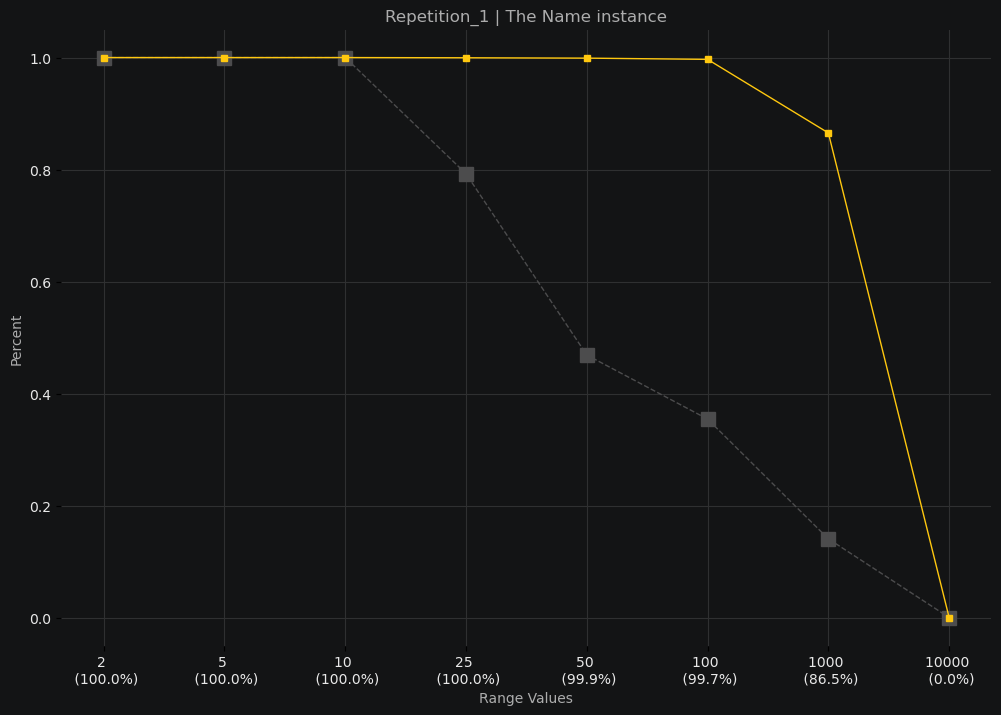

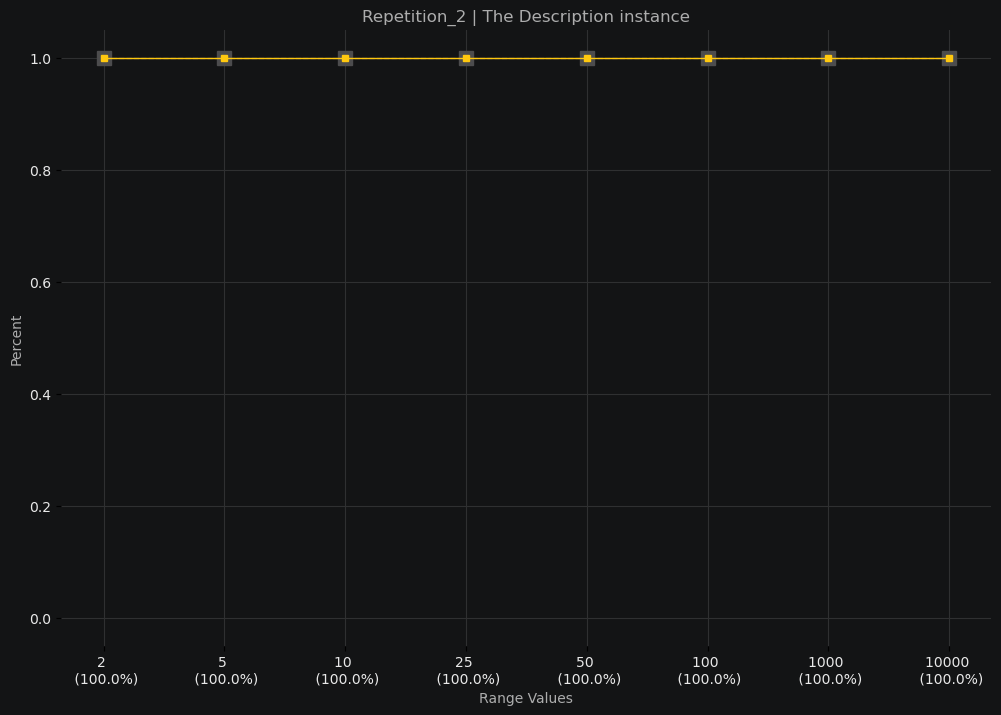

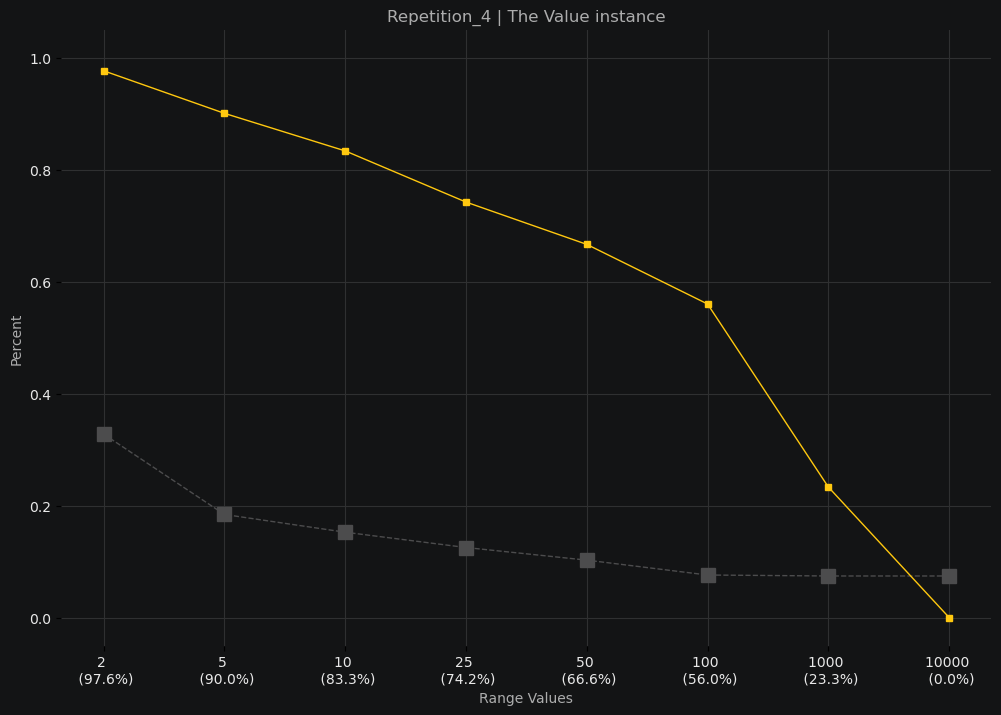

In [43]:
def repetition(dataFrame, df_columns, table_text, analyse_name):
    global MASTER_TABLE
    # finds all duplicate rows and keeps all of them
    df_local = dataFrame[df_columns]
    df_range = df_local[df_local.duplicated(keep=False)]

    # sort based on the first column
    df_range = df_range.sort_values(by=[df_columns[0]])

    # total dataframe count
    df_count = dataFrame.shape[0]

    # count the duplicates
    df_range_group = df_range.groupby(df_range.columns.tolist(),as_index=False, dropna=False, sort=True).size()
    # sort values by count
    df_range_group = df_range_group.sort_values(by="size", ascending=False)
    # reset index
    df_range_group = df_range_group.reset_index(drop=True)

    # print 
    MASTER_TABLE += f"{analyse_name}\n"
    MASTER_TABLE += f"{table_text}\n"

    # if there are no values exit
    if df_range_group.shape[0] == 0:
        MASTER_TABLE += "PASS\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        add_to_cmd_table(analyse_name, "PASS")
        return
    
    add_to_cmd_table(analyse_name, "FIX")

    # go trough the range and add it to the list
    df_range_vals = [2,5,10,25,50,100,1000,10000]
    df_total = []
    df_instances = []
    df_percent = []
    for index, value in enumerate(df_range_vals):
        partition_of_data = df_range_group[df_range_group["size"] >= value]
        partition_of_data_total = partition_of_data.sum()["size"]
        partition_of_data_instances = len(partition_of_data["size"])
        partition_of_data_percent = partition_of_data_total/df_count

        df_total.append(partition_of_data_total)
        df_instances.append(partition_of_data_instances)
        df_percent.append(partition_of_data_percent)

    table = [df_range_vals,df_total,df_instances,df_percent]
    print_table(table, False, ["more or equal to copies ", "data affected", "instance count", "percent"])

    draw_graph(df_range_vals, df_percent, f'{analyse_name} | {table_text}', f'{FOLDER_PATH}/REPETITION/Report-{analyse_name}-Output_2-{filename}-{CURRENT_DATE}.png')   

    # SAVE FILES
    # save - Rows that are duplicated - OUTPUT 1
    df_range_full_table = dataFrame.loc[df_range.index]
    df_range_full_table.to_csv(f'{FOLDER_PATH}/REPETITION/Report-{analyse_name}-Output_1-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')

    # save - Duplicate instances & number of each - OUTPUT 2
    # count the duplicates
    df_range_group = df_range.groupby(df_range.columns.tolist(),as_index=False, dropna=False, sort=True).size()
    # add count to begining
    df_range_group.insert(0, "count", df_range_group["size"])
    # remove size at the end
    df_range_group.pop('size')
    # sort values by count
    df_range_group = df_range_group.sort_values(by="count", ascending=False)
    # reset index
    df_range_group = df_range_group.reset_index(drop=True)
    # save
    df_range_group.to_csv(f'{FOLDER_PATH}/REPETITION/Report-{analyse_name}-Output_2-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')

# REPETITION 1
table_text = 'The Name instance'
repetition(df, ["Name"], table_text, "Repetition_1")

# REPETITION 2
table_text = 'The Description instance'
repetition(df, ["Description"], table_text, "Repetition_2")

try:
    # if (df[["Components"]].isna().sum() == df.shape[0]).bool() == False:
    if (df[["Components"]].isnull().sum() == df.shape[0]).all() == False:
        # REPETITION 3
        table_text = 'The Comp. Items List instance'
        repetition(df, ["Components"], table_text, "Repetition_3")
    else:
        # REPETITION 4
        table_text = 'The Value instance'
        repetition(df, ["Value"], table_text, "Repetition_4")
except:
    print("The dataset does not include all columns")

    # REPETITION 4
    table_text = 'The Value instance'
    repetition(df, ["Value"], table_text, "Repetition_4")
    pass


In [44]:
def format_2(dataFrame, df_columns, analyse_name, description_text):
    global MASTER_TABLE
    
    def check_numbers(item):
        row = item[df_columns[0]]
        if not isinstance(row,float) and not isinstance(row,int) and not isinstance(row, np.int64):
            return True
        else:
            return False
    
    df_local = dataFrame[df_columns]

    df_results = df_local[df_local.apply(check_numbers, axis=1)]

    # check upper case
    count = df_results.shape[0]
    indexes = df_results.index

    # count percent
    df_percent = count / df_local.shape[0]

    # print table
    MASTER_TABLE += f"{analyse_name}\n"
    MASTER_TABLE += f"{description_text}\n"
    
    # if there are no values exit
    if df_percent == 0:
        MASTER_TABLE += "PASS\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"

        add_to_cmd_table(analyse_name, "PASS")
        return
    
    add_to_cmd_table(analyse_name, "FIX", True)

    # table = [["of rows where the Value column items does not contain a number"],[f"{format_number_with_commas(count)}/{format_number_with_commas(df_local.shape[0])} | {df_percent}"]]
    # print_table(table, True)

    table = [[df_columns[0]], [df_percent], [count]]
    print_table(table, False, ["Column", "Percentage", "Count"])

    # save document
    df_full_table = dataFrame.loc[indexes]
    df_full_table.to_csv(f'{FOLDER_PATH}/FORMATTING/Report-{analyse_name}-Output_1-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')
            
format_2(df, ["Value"], "Formatting_2", "of rows where the Value column items does not contain a number")

In [45]:
def format_all_columns(dataFrame, df_columns, regex, analyse_name, description_text):
    global MASTER_TABLE

    # drop source as it always has double characters
    df_local = dataFrame[df_columns].drop("Source", axis=1)

    indexes = []
    output_count = []

    # go trough columns and check whether in any of those there is a questionmark
    for index, item in enumerate(df_local.columns):
        # stringify the column
        # temp = dataFrame[item].astype(str).str.replace('.', '', regex=True)
        temp = dataFrame[item].astype(str)
        search_range = temp[temp.str.contains(regex)]
        
        # set indexes to search range ndexes
        indexes = search_range.index.tolist()

        # append to output count
        output_count.append(str(len(indexes)))

        # save file if found
        if len(indexes) > 0:
            # create a file name
            cn = re.sub("[^A-Z]", " ", item,0,re.IGNORECASE)
            cn = re.sub(' +', '_', cn)

            # save document
            df_full_table = dataFrame.loc[indexes]
            df_full_table.to_csv(f'{FOLDER_PATH}/FORMATTING/Report-{analyse_name}-{cn}-Output_1-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')

    # calculate percentages
    output_percentages = [int(i) / df_local.shape[0] for i in output_count]

    # print table
    MASTER_TABLE += f"{analyse_name}\n"
    MASTER_TABLE += f"{description_text}\n"

    # if there are no values exit
    if  len([x for x in output_count if int(x) != 0]) == 0:
        MASTER_TABLE += "PASS\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        add_to_cmd_table(analyse_name, "PASS")
        return
    
    add_to_cmd_table(analyse_name, "FIX", True)

    # Convert output_count from strings to integers
    # output_count = [int(count) for count in output_count]

    # Get indexes where output_count is 1
    indexes_with_one = [index for index, count in enumerate(output_count) if int(count) > 0]

    # Filter percentages, counts, and columns by these indexes
    filtered_percentages = [output_percentages[index] for index in indexes_with_one]
    filtered_counts = [output_count[index] for index in indexes_with_one]
    filtered_columns = [df_local.columns[index] for index in indexes_with_one]

    table = [filtered_columns, filtered_percentages, filtered_counts]
    # print(table)
    
    # table = [df_local.columns.tolist(), output_percentages, output_count]
    print_table(table, False, ["Column", "Percentage", "Count"])

regex = r"([^A-Za-z0-9 ])\1"
description_text = "% of rows with a doubled character that is not a letter or number in any column & count"
format_all_columns(df, df.columns, regex, "Formatting_3", description_text)

regex = r"([ ])\1"
description_text = "% of rows with a doubled space in any column & count"
format_all_columns(df, df.columns, regex, "Formatting_4",description_text)

regex = r"([?])"
description_text = "% of rows with a question mark in any column & count"
format_all_columns(df, df.columns, regex, "Formatting_5",description_text)

In [46]:
def format_6(dataFrame, df_columns, analyse_name, description_text):
    global MASTER_TABLE
    
    # check whether df_local contains a value from df_geographies 
    def check_geography(item):
        try:
            row = item[df_columns[0]]
            if row not in df_geography.values:
                return True
            return False
        except:
            print(f"Exception, inspect it : {item}")
            return True

    # take only the columns that are needed
    df_local = dataFrame[df_columns]

    df_results = df_local[df_local.apply(check_geography, axis=1)]

    # check upper case
    count = df_results.shape[0]
    indexes = df_results.index

    # count percent
    df_percent = count / df_local.shape[0]

    # print table
    MASTER_TABLE += f"{analyse_name}\n"
    MASTER_TABLE += f"{description_text}\n"
    
    # if there are no values exit
    if count == 0:
        MASTER_TABLE += "of rows not in geograpies list\n"
        MASTER_TABLE += "PASS\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"

        add_to_cmd_table(analyse_name, "PASS")
        return
    
    add_to_cmd_table(analyse_name, "FIX", True)
    
    # table = [["of rows not in geograpies list"],[f"{format_number_with_commas(count)} / {format_number_with_commas(df_local.shape[0])} | {df_percent}"]]
    # print_table(table, True)

    table = [[df_columns[0]], [df_percent], [count]]
    print_table(table, False, ["Column", "Percentage", "Count"])

    # save document
    df_full_table = dataFrame.loc[indexes]
    df_full_table.to_csv(f'{FOLDER_PATH}/FORMATTING/Report-{analyse_name}-Output_1-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')


if (df[["Region/Regional Scope"]].isnull().sum() == df.shape[0]).all() == False:            
    format_6(df, ["Region/Regional Scope"], "Formatting_6", "of rows not in geograpies list")
else:
    print("No Region/Regional Scope")
    # print table
    MASTER_TABLE += "Formatting_6\n"
    MASTER_TABLE += "of rows not in geograpies list\n"
    MASTER_TABLE += "No Region/Regional Scope \n"
    MASTER_TABLE += "-\n"
    MASTER_TABLE += "-\n"
    MASTER_TABLE += "-\n"

In [47]:
def format_7(dataFrame, df_columns, analyse_name, description_text):
    global MASTER_TABLE
    
    # check whether df_local contains a value from df_geographies 
    def check_date(item):
        try:
            row = str(item[df_columns[0]])  # Convert the value to a string
            # Define regex patterns for yyyy-dd-mm and yyyy
            pattern_yyyy_dd_mm = re.compile(r'^\d{4}-\d{2}-\d{2}$')
            pattern_yyyy = re.compile(r'^\d{4}$')
            
            # Check if the row matches either pattern
            if not (pattern_yyyy_dd_mm.match(row) or pattern_yyyy.match(row)):
                return True
            return False
        except Exception as e:
            print(f"Exception, inspect it : {item}, Error: {e}")
            return True

    # take only the columns that are needed
    df_local = dataFrame[df_columns]

    df_results = df_local[df_local.apply(check_date, axis=1)]

    # check upper case
    count = df_results.shape[0]
    indexes = df_results.index

    # count percent
    df_percent = count / df_local.shape[0]

    # print table
    MASTER_TABLE += f"{analyse_name}\n"
    MASTER_TABLE += f"{description_text}\n"
    
    # if there are no values exit
    if count == 0:
        MASTER_TABLE += "of rows not in correct date format\n"
        MASTER_TABLE += "PASS\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"

        add_to_cmd_table(analyse_name, "PASS")
        return
    
    add_to_cmd_table(analyse_name, "FIX", True)
    
    # table = [["of rows not in correct date format"],[f"{format_number_with_commas(count)} / {format_number_with_commas(df_local.shape[0])} | {df_percent}"]]
    # print_table(table, True)
    
    table = [[df_columns[0]], [df_percent], [count]]
    print_table(table, False, ["Column", "Percentage", "Count"])

    # save document
    df_full_table = dataFrame.loc[indexes]
    df_full_table.to_csv(f'{FOLDER_PATH}/FORMATTING/Report-{analyse_name}-Output_1-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')


if (df[["Sample/Representative Date"]].isnull().sum() == df.shape[0]).all() == False:            
    format_7(df, ["Sample/Representative Date"], "Formatting_7", "of rows not in correct date format")
else:
    print("No Sample/Representative Date")
    # print table
    MASTER_TABLE += "Formatting_7\n"
    MASTER_TABLE += "of rows not in correct date format\n"
    MASTER_TABLE += "No Sample/Representative Date \n"
    MASTER_TABLE += "-\n"
    MASTER_TABLE += "-\n"
    MASTER_TABLE += "-\n"
    

In [48]:
def format_8(dataFrame, df_columns, analyse_name, description_text):
    global MASTER_TABLE
    
    # check whether df_local contains a value from df_units 
    def check_unit(item):
        try:
            row = item[df_columns[0]]
            if row not in df_units.values:
                return True
            return False
        except:
            print(f"Exception, inspect it : {item}")
            return True

    # take only the columns that are needed
    df_local = dataFrame[df_columns]

    df_results = df_local[df_local.apply(check_unit, axis=1)]

    # check upper case
    count = df_results.shape[0]
    indexes = df_results.index

    # count percent
    df_percent = count / df_local.shape[0]

    # print table
    MASTER_TABLE += f"{analyse_name}\n"
    MASTER_TABLE += f"{description_text}\n"
    
    # if there are no values exit
    if count == 0:
        MASTER_TABLE += "of rows not in correct unit format\n"
        MASTER_TABLE += "PASS\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"
        MASTER_TABLE += "-\n"

        add_to_cmd_table(analyse_name, "PASS")
        return
    
    add_to_cmd_table(analyse_name, "FIX", True)
    
    # table = [["of rows not in correct unit format"],[f"{format_number_with_commas(count)}/{format_number_with_commas(df_local.shape[0])} | {df_percent}"]]
    # print_table(table, True)

    table = [[df_columns[0]], [df_percent], [count]]
    print_table(table, False, ["Column", "Percentage", "Count"])

    # save document
    df_full_table = dataFrame.loc[indexes]
    df_full_table.to_csv(f'{FOLDER_PATH}/FORMATTING/Report-{analyse_name}-Output_1-{filename}-{CURRENT_DATE}.csv',encoding='utf-8')


if (df[["Unit"]].isnull().sum() == df.shape[0]).all() == False:            
    format_8(df, ["Unit"], "Formatting_8", "of rows not in correct unit format")
else:
    print("No Units")
    # print table
    MASTER_TABLE += "Formatting_8\n"
    MASTER_TABLE += "of rows not in correct unit format\n"
    MASTER_TABLE += "No Units \n"
    MASTER_TABLE += "-\n"
    MASTER_TABLE += "-\n"
    MASTER_TABLE += "-\n"
    

In [49]:
def save_table ():
    global MASTER_TABLE
    fname = f'{FOLDER_PATH}/Report-{filename}-{CURRENT_DATE}.csv'
    with open(f'{fname}', 'w', newline='') as f_output:
        f_output.write(MASTER_TABLE)
save_table()

In [50]:
def save_pdf():
    global MASTER_TABLE
    fname = f'{FOLDER_PATH}/Report-{filename}-{CURRENT_DATE}.pdf'
    
    # Parse the CSV data in MASTER_TABLE
    csv_data = StringIO(MASTER_TABLE)
    reader = csv.reader(csv_data)
    all_rows = [row for row in reader]  # Read all rows into a list
    
    # Split data into separate tables based on the separator
    tables = []
    current_table = []
    for row in all_rows:
        if row == ["-"]:
            if current_table:
                tables.append(current_table)
                current_table = []
        else:
            current_table.append(row)
    if current_table:
        tables.append(current_table)
    
    # Create a PDF document
    pdf = SimpleDocTemplate(fname, pagesize=letter)
    elements = []
    styles = getSampleStyleSheet()
    
    # Define custom styles for headline and subheadline
    error_style = ParagraphStyle(
        name='Headline', 
        parent=styles['Heading2'], 
        fontName='Helvetica-Bold',
        textColor= colors.HexColor("#FFC80F"),  # Set the line color to gray
        fontSize=10, 
        spaceBefore=16, 
        spaceAfter=8
    )

    headline_style = ParagraphStyle(
        name='Headline', 
        parent=styles['Heading2'], 
        fontName='Helvetica-Bold',
        textColor= colors.HexColor("#E9E9E9"),  # Set the line color to gray
        fontSize=10, 
        spaceBefore=16, 
        spaceAfter=8
    )
    subheadline_style = ParagraphStyle(
        name='Subheadline', 
        parent=styles['Heading3'], 
        fontName='Helvetica',
        textColor= colors.HexColor("#B1B1B1"),  # Set the line color to gray
        fontSize=10, 
        spaceBefore=8, 
        spaceAfter=8
    )

    pass_style = ParagraphStyle(
        name='Pass', 
        parent=styles['BodyText'], 
        fontSize=10, 
        textColor= colors.HexColor("#B1B1B1"),  # Set the line color to gray
        fontName='Helvetica',
        spaceBefore=8,
        spaceAfter=8,
    )

    body_style = ParagraphStyle(
        name='Pass', 
        parent=styles['BodyText'], 
        fontSize=10, 
        textColor= colors.HexColor("#E9E9E9"),  # Set the line color to gray
        fontName='Helvetica',
        spaceBefore=8,
        spaceAfter=8,
    )

    body_style_err = ParagraphStyle(
        name='Pass', 
        parent=styles['BodyText'], 
        fontSize=10, 
        textColor= colors.HexColor("#FFC80F"),  # Set the line color to gray
        fontName='Helvetica',
        spaceBefore=8,
        spaceAfter=8,
    )

    # Create Table objects for each table and add them to the PDF
    for i, table_data in enumerate(tables):
        if table_data:
            # Treat the first row as a headline
            headline = table_data[0]

            if "Repetition" in headline[0] or "Formatting_2" in headline[0] or "Missing_value_mandatory" in headline[0] or "Missing_value_optional" in headline[0]:
                elements.append(PageBreak())  # Add a new page
            
            # Check if the second row is a subheadline
            if len(table_data) > 1 and len(table_data[1]) == 1:
                subheadline = table_data[1]

                if subheadline == ["PASS"]:
                    elements.append(Paragraph(" ".join(headline), headline_style))
                    elements.append(Paragraph(" ".join(subheadline), pass_style))
                else:
                    # only error in non total data points or repetition
                    if "Formatting" in headline[0] and table_data[2] != ["PASS"]:
                        elements.append(Paragraph(" ".join(headline), error_style))
                    elif "Duplication" in headline[0]:
                        elements.append(Paragraph(" ".join(headline), error_style))
                    else:
                        elements.append(Paragraph(" ".join(headline), headline_style))
                        pass
                    elements.append(Paragraph(" ".join(subheadline), subheadline_style))
                table_data = table_data[2:]  # Remove headline and subheadline rows
                
                # Check if the next line is "pass" and treat it as a subheadline if it is
                if len(table_data) > 0 and table_data[0] == ["PASS"]:
                    elements.append(Paragraph(" ".join(table_data[0]), pass_style))
                    elements.append(Spacer(1, 12))
                    table_data = table_data[1:]  # Remove the "pass" row
            else:
                subheadline = table_data[1]
                if ("Missing_value_mandatory" in headline[0] or "Duplication" in headline[0] or "Non_discerning_info" in headline[0]) and subheadline != ["PASS"]:
                    elements.append(Paragraph(" ".join(headline), error_style))
                else:
                    # if headline is Missing_value_optional
                    if "Missing_value_optional" in headline[0]:
                        # check weather there are any numbers in the table_data
                        has_numbers = any(isinstance(convert_to_number(cell), (int, float)) for row in table_data for cell in row)
                        if has_numbers:
                            elements.append(Paragraph(" ".join(headline), error_style))
                        else:
                            elements.append(Paragraph(" ".join(headline), headline_style))
                    else:
                        elements.append(Paragraph(" ".join(headline), headline_style))
                table_data = table_data[1:]  # Remove only the headline row
            
            # Create the table without the headline (and subheadline) rows
            if len(table_data) == 0:
                draw_line(elements)
                continue

            # Define padding
            padding = 48  # Adjust this value as needed

            # Calculate the width of each column
            page_width = letter[0]  # Width of the letter page size
            adjusted_page_width = page_width - (2 * padding)  # Subtract padding from both sides
            num_columns = len(table_data[0])  # Number of columns in the table
            col_width = adjusted_page_width / num_columns  # Width of each column
            
            # Wrap cell content in Paragraphs to enable word wrapping
            table_data = [[Paragraph(cell, body_style) for cell in row] for row in table_data]

                        # if headline is Missing_value_optional
            if "Missing_value" in headline[0]:
                # go trough all values and if value is a number then color it differently
                for i, row in enumerate(table_data):
                    for j, cell in enumerate(row):
                        if isinstance(convert_to_number(cell.getPlainText()), (int, float)):
                                # table.setStyle(TableStyle([('TEXTCOLOR', (j, i), (j, i), colors.HexColor("#FFC80F"))]))
                                table_data[i][j] = Paragraph(cell.getPlainText(), body_style_err)

            # Create the table with equal column widths
            table = Table(table_data, colWidths=[col_width] * num_columns)
            
            # Add style to the table
            style = TableStyle([
                ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#212223')),
                ('TEXTCOLOR', (0, 0), (-1, 0), colors.HexColor("#E9E9E9")),
                ('TEXTCOLOR', (0, 0), (-1, -1), colors.HexColor("#E9E9E9")),
                ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
                
                ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                ('FONTSIZE', (0, 0), (-1, -1), 10),
                
                ('BOTTOMPADDING', (0, 0), (-1, 0), 4),
				('ROWBACKGROUNDS', (0, 1), (-1, -1), [colors.HexColor('#131415'), colors.HexColor('#18191A') ]),
                ('LINEBEFORE', (1, 0), (-1, -1), 1, colors.HexColor('#2F3031')),  # Vertical lines before each column

                ('WORDWRAP', (0, 0), (-1, -1), 'CJK'),  # Enable word wrap for all cells
            ])
            table.setStyle(style)


            
            elements.append(table)
            
            # if it is repetition add graph
            if "Repetition" in headline[0]:
                graph_png_path = find_png_file(f"{FOLDER_PATH}/REPETITION", headline[0])[0]
                add_graph_image(elements, graph_png_path)


            elements.append(Spacer(1, 16))  # Add some space after the line
            draw_line(elements)

    pdf = SimpleDocTemplate(
        fname,
        leftMargin=padding-16,
        rightMargin=padding-16,
        topMargin=padding-16,
        bottomMargin=padding-16
    )

    # Define a custom PageTemplate with a background color
    def add_background(canvas, doc):
        canvas.saveState()
        canvas.setFillColor(colors.HexColor('#131415'))
        canvas.rect(0, 0, letter[0], letter[1] + 64, fill=1)
        canvas.restoreState()

    frame = Frame(pdf.leftMargin, pdf.bottomMargin, pdf.width, pdf.height, id='normal')
    template = PageTemplate(id='background', frames=frame, onPage=add_background)
    pdf.addPageTemplates([template])
    
    # Build the PDF
    pdf.build(elements, onFirstPage=add_background, onLaterPages=add_background)

def add_graph_image(elements, path):
    elements.append(Image(path, width=600, height=400))

def draw_line(elements):
    # Add a horizontal line after the table
    elements.append(Spacer(1, 6))  # Add some space after the line
    # Get the width of the page
    page_width = letter[0]
    # Create a line that spans the full width of the page
    line = Drawing(page_width, 1)
    gray_line = Line(-64, 0, page_width, 0)  # Set the length of the line to the page width
    gray_line.strokeColor = colors.HexColor("#2F3031")  # Set the line color to gray
    line.add(gray_line)
    elements.append(line)
    elements.append(Spacer(1, 6))  # Add some space after the line

def find_png_file(folder_path, headline):
    # Use glob to find all PNG files in the specified folder
    png_files = glob.glob(os.path.join(folder_path, '*.png'))
     # Filter the files to find those that contain the headline in their path
    matching_files = [png_file for png_file in png_files if headline in os.path.basename(png_file)]
    
    return matching_files

def convert_to_number(cell):
    try:
        # Try to convert to integer
        return int(cell)
    except ValueError:
        try:
            # If integer conversion fails, try to convert to float
            return float(cell)
        except ValueError:
            # If both conversions fail, return the original string
            return cell
save_pdf()

In [51]:
def split_files(directory):
    # Go through directory and split files
    # fname = f'{FOLDER_PATH}/Report-{filename}-{CURRENT_DATE}.csv'
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            # check whether the file ending is csv
            if f[-3:] == "csv":
                # print(f)
                # check size of the file
                if os.path.getsize(f) > 50000000:
                    print(f'splitting : {filename}')
                    # make chunk out of big page
                    chunkFolder = f"{directory}/{filename[:-4]}/"
                    if not os.path.exists(chunkFolder):
                        os.mkdir(chunkFolder)
                    for i,chunk in enumerate(pd.read_csv(f, chunksize=250000)):
                        chunk.to_csv(chunkFolder+f'{filename[:-4]}'+'-{}.csv'.format(i), index=False)
                        print(i)
                    # remove file from the system
                    os.remove(f)
        if os.path.isdir(f):
            split_files(f)
split_files(FOLDER_PATH)

In [52]:
# Only make an archive if zip is True
if zip:
    shutil.make_archive(folder_to_download, 'zip', folder_to_download)
    filelink = folder_to_download+'.zip'
    FileLink(filelink)

In [53]:
# Column headers
headers = ["Name", "Value"]
colalign = ("left", "left")
print(tabulate(CMD_TABLE, headers, tablefmt="pretty", colalign=colalign))

+-------------------------+-------+
| Name                    | Value |
+-------------------------+-------+
| Duplication             | FIX   |
| Non_discerning_info     | FIX   |
| Missing_value_mandatory | FIX   |
| Repetition_1            | FIX   |
| Repetition_2            | FIX   |
| Repetition_4            | FIX   |
| Formatting_2            | FIX   |
| Formatting_3            | FIX   |
| Formatting_4            | FIX   |
| Formatting_5            | FIX   |
| Formatting_6            | FIX   |
| Formatting_7            | FIX   |
| Formatting_8            | FIX   |
+-------------------------+-------+
